# Rarefaction analysis
* Evaluate sampling of the community at sequencing depth

In [1]:
figDir = '~/Hyphosphere/data/3Exp/figures'

work_dir = '~/Hyphosphere/data/3Exp/DESeq'

# phyloseq - full object without tree (includes archaea)
physeq_file = '~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_full.rds'

In [2]:
library(RColorBrewer)
library(vegan)
library(ggpubr)
library(phyloseq)
library(gridExtra)
library(ggplot2)
library(tidyr)
library(dplyr)
library(reshape2)


Warning message:
“package ‘RColorBrewer’ was built under R version 3.6.1”Warning message:
“package ‘vegan’ was built under R version 3.6.1”Loading required package: permute
Warning message:
“package ‘permute’ was built under R version 3.6.1”Loading required package: lattice
Warning message:
“package ‘lattice’ was built under R version 3.6.1”This is vegan 2.5-5
Loading required package: ggplot2
Warning message:
“package ‘ggplot2’ was built under R version 3.6.1”Warning message:
“package ‘phyloseq’ was built under R version 3.6.1”
Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘reshape2’ was built under R version 3.6.1”
Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [3]:
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

In [4]:
ps = readRDS(physeq_file) 
ps
ps = ps %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    
    subset_samples(., SampleType != "GV") 
    # T0R1 has all NaN for some reason
    #subset_samples(!Sample == "T0R1") #%>%
     # re-normalize after subsetting taxa
    #transform_sample_counts(., function(x) x/sum(x))
sample_data(ps)$Rep = as.factor(sample_data(ps)$Rep)

ps


                                  


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 61130 taxa and 434 samples ]
sample_data() Sample Data:       [ 434 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 61130 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 58105 taxa and 433 samples ]
sample_data() Sample Data:       [ 433 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 58105 taxa by 8 taxonomic ranks ]

# Try the phyloseq based function

In [5]:


calculate_rarefaction_curves <- function(psdata, measures, depths) {
  require('plyr') # ldply
  require('reshape2') # melt

  estimate_rarified_richness <- function(psdata, measures, depth) {
    if(max(sample_sums(psdata)) < depth) return()
    psdata <- prune_samples(sample_sums(psdata) >= depth, psdata)

    rarified_psdata <- rarefy_even_depth(psdata, depth, verbose = FALSE)

    alpha_diversity <- estimate_richness(rarified_psdata, measures = measures)

    # as.matrix forces the use of melt.array, which includes the Sample names (rownames)
    molten_alpha_diversity <- melt(as.matrix(alpha_diversity), varnames = c('Sample', 'Measure'), value.name = 'Alpha_diversity')

    molten_alpha_diversity
  }

  names(depths) <- depths # this enables automatic addition of the Depth to the output by ldply
  rarefaction_curve_data <- ldply(depths, estimate_rarified_richness, psdata = psdata, measures = measures, .id = 'Depth', .progress = ifelse(interactive(), 'text', 'none'))

  # convert Depth from factor to numeric
  rarefaction_curve_data$Depth <- as.numeric(levels(rarefaction_curve_data$Depth))[rarefaction_curve_data$Depth]

  rarefaction_curve_data
}



In [6]:
set.seed(101)
tmp = ps %>% subset_samples(., Experiment == 1 & Fungus == "Gv")

Exp1_rarefaction_curve_data <- calculate_rarefaction_curves(tmp, c('Observed'), rep(c(1, 10, 1:10 * 10, 1:10 * 100, 1:10 * 1000, 1:25 * 5000), each = 10))
summary(Exp1_rarefaction_curve_data)

Loading required package: plyr
Warning message:
“package ‘plyr’ was built under R version 3.6.1”------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:ggpubr’:

    mutate



     Depth              Sample          Measure      Alpha_diversity 
 Min.   :    1   HCRN2_S272:  410   Observed:13260   Min.   :   1.0  
 1st Qu.:   80   HCRN3_S284:  410                    1st Qu.:  53.0  
 Median :  700   HCRF3_S225:  400                    Median : 176.0  
 Mean   : 3864   HCRN1_S260:  400                    Mean   : 335.3  
 3rd Qu.: 5000   HCRP2_S249:  400                    3rd Qu.: 550.0  
 Max.   :45000   HCBN2_S223:  390                    Max.   :1662.0  
                 (Other)   :10850                                    

## Summarize rarefaction data

In [7]:
Exp1_rarefaction_curve_data_summary <- ddply(Exp1_rarefaction_curve_data, c('Depth', 'Sample', 'Measure'), summarise, Alpha_diversity_mean = mean(Alpha_diversity), Alpha_diversity_sd = sd(Alpha_diversity))

## Add sample data back

In [8]:
Exp1_rarefaction_curve_data_summary_verbose <- merge(Exp1_rarefaction_curve_data_summary, data.frame(sample_data(tmp)), by.x = 'Sample', by.y = 'row.names')

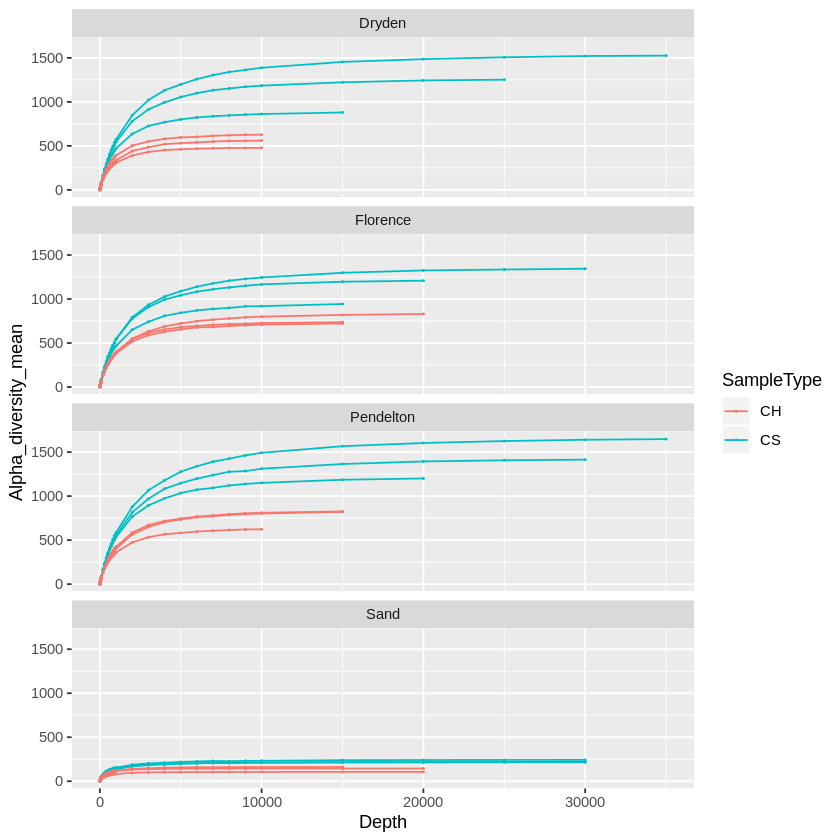

In [9]:
plot_data = Exp1_rarefaction_curve_data_summary_verbose %>% filter(SampleType %in% c("CH", "CS"))
ggplot(
  data = plot_data,
  mapping = aes(
    x = Depth,
    y = Alpha_diversity_mean,
    ymin = Alpha_diversity_mean - Alpha_diversity_sd,
    ymax = Alpha_diversity_mean + Alpha_diversity_sd,
    colour = SampleType,
    group = Sample)) + 
    geom_line() + 
    geom_point(size = 0.2) +
    facet_wrap(facets = ~ Soil, ncol = 1)

## Experiment 2

In [71]:
set.seed(101)
tmp = ps %>% subset_samples(., Experiment == 2)

Exp2_rarefaction_curve_data <- calculate_rarefaction_curves(tmp, c('Observed'), rep(c(1, 10, 1:10 * 10, 1:10 * 100, 1:10 * 1000, 3:25 * 5000), each = 10))
summary(Exp2_rarefaction_curve_data)

     Depth              Sample          Measure      Alpha_diversity 
 Min.   :    1   GVCLHN2.BS:  460   Observed:68670   Min.   :   1.0  
 1st Qu.:   80   RIN7HP2.CH:  460                    1st Qu.:  65.0  
 Median :  800   GVCLHN2.BH:  450                    Median : 309.0  
 Mean   : 7230   GVN7HN2.RH:  450                    Mean   : 497.9  
 3rd Qu.: 8000   GVN7HN2.RS:  450                    3rd Qu.: 908.0  
 Max.   :80000   GVN7HN4.RH:  450                    Max.   :2019.0  
                 (Other)   :65950                                    

In [103]:
Exp2_rarefaction_curve_data %>% head()

Depth,Sample,Measure,Alpha_diversity
1,GVCLHN1.BH,Observed,1
1,GVCLHN1.BP,Observed,1
1,GVCLHN1.BS,Observed,1
1,GVCLHN1.CH,Observed,1
1,GVCLHN1.CS,Observed,1
1,GVCLHN1.RH,Observed,1


In [123]:
Exp2_rarefaction_curve_data_summary <- ddply(Exp2_rarefaction_curve_data, c('Depth', 'Sample', 'Measure'), summarise, Alpha_diversity_mean = mean(Alpha_diversity), Alpha_diversity_sd = sd(Alpha_diversity))
Exp2_rarefaction_curve_data_summary = Exp2_rarefaction_curve_data_summary %>% mutate(Sample = gsub("\\.", "-", Sample))
head(Exp2_rarefaction_curve_data_summary)

Depth,Sample,Measure,Alpha_diversity_mean,Alpha_diversity_sd
1,GVCLHN1-BH,Observed,1,0
1,GVCLHN1-BP,Observed,1,0
1,GVCLHN1-BS,Observed,1,0
1,GVCLHN1-CH,Observed,1,0
1,GVCLHN1-CS,Observed,1,0
1,GVCLHN1-RH,Observed,1,0


In [129]:
Exp2_rarefaction_curve_data_summary_verbose <- merge(Exp2_rarefaction_curve_data_summary, data.frame(sample_data(tmp)), by = "Sample")
head(Exp2_rarefaction_curve_data_summary_verbose)

Sample,Depth,Measure,Alpha_diversity_mean,Alpha_diversity_sd,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul
GVCLHN1-BH,1,Observed,1.00,0.000000,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,80,Observed,73.80,1.932184,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,40000,Observed,1381.10,3.281260,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,9000,Observed,1229.80,9.772979,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,1000,Observed,532.05,13.915062,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,200,Observed,164.00,5.617433,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA


In [131]:
plot_data = Exp2_rarefaction_curve_data_summary_verbose #%>% filter(SampleType %in% c("CH", "CS", "BS"))
head(plot_data)

Sample,Depth,Measure,Alpha_diversity_mean,Alpha_diversity_sd,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul
GVCLHN1-BH,1,Observed,1.00,0.000000,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,80,Observed,73.80,1.932184,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,40000,Observed,1381.10,3.281260,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,9000,Observed,1229.80,9.772979,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,1000,Observed,532.05,13.915062,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA
GVCLHN1-BH,200,Observed,164.00,5.617433,2,GVCLHN1,Gv,Pendelton,BH,HN,NA,27,1,NA


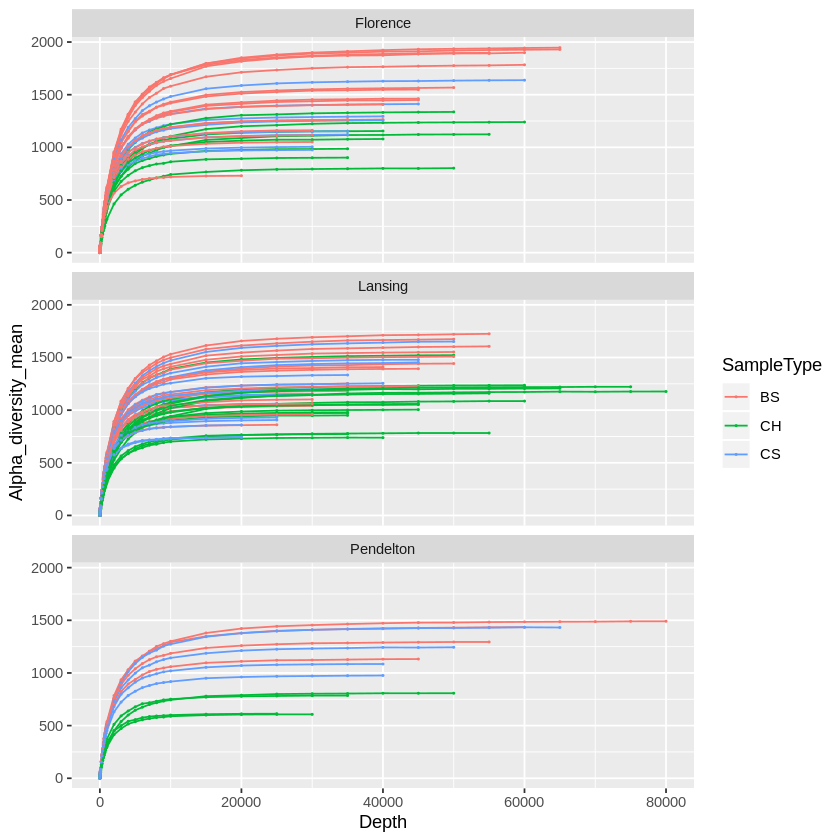

In [132]:
plot_data = Exp2_rarefaction_curve_data_summary_verbose %>% filter(SampleType %in% c("CH", "CS", "BS"))

ggplot(
  data = plot_data,
  mapping = aes(
    x = Depth,
    y = Alpha_diversity_mean,
    ymin = Alpha_diversity_mean - Alpha_diversity_sd,
    ymax = Alpha_diversity_mean + Alpha_diversity_sd,
    colour = SampleType,
    group = Sample)) + 
    geom_line() + 
    geom_point(size = 0.2) +
    facet_wrap(facets = ~ Soil, ncol = 1)

## Experiment 3

In [50]:
set.seed(101)
tmp = ps %>% subset_samples(., Experiment == 3 & Fungus == "Gv")

Exp3_rarefaction_curve_data <- calculate_rarefaction_curves(tmp, c('Observed'), rep(c(1, 10, 1:10 * 10, 1:10 * 100, 1:10 * 1000, 3:25 * 5000), each = 10))
summary(Exp3_rarefaction_curve_data)

     Depth            Sample          Measure      Alpha_diversity 
 Min.   :     1   X2.3CH :  520   Observed:63080   Min.   :   1.0  
 1st Qu.:    80   X2.1CH :  480                    1st Qu.:  58.0  
 Median :   700   X3.1CH :  460                    Median : 238.0  
 Mean   :  5712   X6.5BP :  460                    Mean   : 465.3  
 3rd Qu.:  6000   X1.2BP :  440                    3rd Qu.: 754.0  
 Max.   :110000   X2.1CS :  440                    Max.   :2262.0  
                  (Other):60280                                    

In [52]:
Exp3_rarefaction_curve_data_summary <- ddply(Exp3_rarefaction_curve_data, c('Depth', 'Sample', 'Measure'), summarise, Alpha_diversity_mean = mean(Alpha_diversity), Alpha_diversity_sd = sd(Alpha_diversity))

In [63]:
Exp3_rarefaction_curve_data_summary = Exp3_rarefaction_curve_data_summary %>% mutate(Sample = gsub("X", "", Sample)) 
Exp3_rarefaction_curve_data_summary %>% head()

Depth,Sample,Measure,Alpha_diversity_mean,Alpha_diversity_sd
1,1.1BP,Observed,1,0
1,1.1BS,Observed,1,0
1,1.1CH,Observed,1,0
1,1.1CS,Observed,1,0
1,1.1RH,Observed,1,0
1,1.1RT,Observed,1,0


In [64]:
Exp3_rarefaction_curve_data_summary_verbose <- merge(Exp3_rarefaction_curve_data_summary, data.frame(sample_data(tmp)), by.x = 'Sample', by.y = 'row.names')

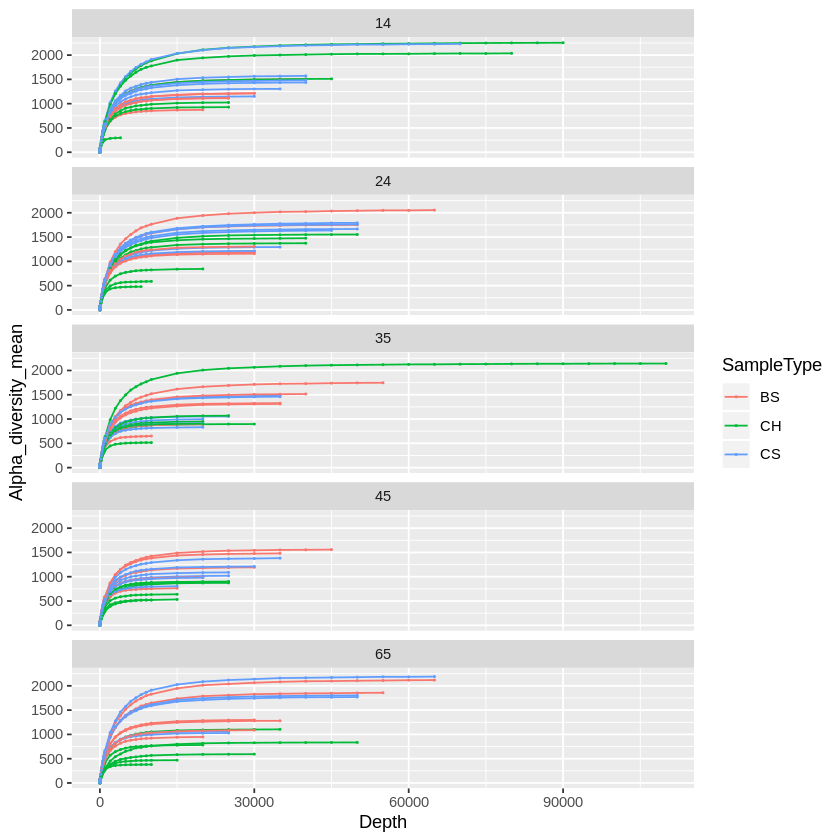

In [65]:
plot_data = Exp3_rarefaction_curve_data_summary_verbose %>% filter(SampleType %in% c("CH", "CS", "BS"))
ggplot(
  data = plot_data,
  mapping = aes(
    x = Depth,
    y = Alpha_diversity_mean,
    ymin = Alpha_diversity_mean - Alpha_diversity_sd,
    ymax = Alpha_diversity_mean + Alpha_diversity_sd,
    colour = SampleType,
    group = Sample)) + 
    geom_line() + 
    geom_point(size = 0.2) +
    facet_wrap(facets = ~ DAI, ncol = 1)